<a href="https://colab.research.google.com/github/hfoffani/HF-fastai/blob/main/nb20_iula_blurr_highapi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq transformers tqdm
!pip install -Uqq ohmeow-blurr
# !pip install -Uqq wandb

     |████████████████████████████████| 2.6 MB 6.8 MB/s 
     |████████████████████████████████| 76 kB 5.3 MB/s 
     |████████████████████████████████| 636 kB 62.4 MB/s 
     |████████████████████████████████| 3.3 MB 54.3 MB/s 
     |████████████████████████████████| 895 kB 62.8 MB/s 
     |████████████████████████████████| 75 kB 3.5 MB/s 
     |████████████████████████████████| 43 kB 2.9 MB/s 
     |████████████████████████████████| 264 kB 31.2 MB/s 
     |████████████████████████████████| 1.2 MB 54.8 MB/s 
     |████████████████████████████████| 188 kB 55.2 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 118 kB 62.9 MB/s 
     |████████████████████████████████| 243 kB 58.8 MB/s 


In [2]:
import os
import glob
import pandas as pd

from blurr.modeling.core import BlearnerForSequenceClassification

from fastai.text.all import ColSplitter, F1Score, accuracy, load_learner

### Leer Corpus

In [3]:
co_df = pd.read_csv('/content/drive/MyDrive/iula-es.csv')
num_labels = co_df['label'].nunique()
co_df

,label,sentence,is_valid
0,economía,LOS POSTULADOS DE LA ECONOMÍA CLÁSICA,True
1,economía,"La mayor parte de los tratados sobre la teoría del valor y de la producción se refieren, en primer término, a la distribución de un volumen dado de recursos empleados en diferentes usos, y a las condiciones que, supuesta la ocupación de esta cantidad de recursos, determinen su remuneración relativa y el relativo valor de sus productos [1]",False
2,economía,"También se ha sujetado con frecuencia a un procedimiento descriptivo lo relativo al monto de los recursos disponibles (entendiendo por tales el volumen de población susceptible de tomar empleo), los límites de la riqueza natural y el equipo de producción acumulado; pero rara vez se ha examinado detenidamente en la teoría pura, la explicación de lo que determina la ocupación real de los recursos disponibles.",False
3,economía,"Decir que no se ha considerado en absoluto, seria absurdo, por supuesto; porque todo estudio sobre los altibajos de la ocupación, que han sido muchos, ha tenido que ver con el tema.",False
4,economía,"No quiero decir que se haya pasado por alto, sino que la teoría fundamental en que descansa se ha creído tan sencilla y evidente que casi no había para qué mencionarla [2]",False
...,...,...,...
52350,medicina,Diarrea.,True
52351,medicina,Debilidad.,False
52352,medicina,Gusto alterado.,False
52353,medicina,Parestesias peribucales.,False


### Modelar

In [4]:

# pretained models
#   "distilbert-base-uncased"
#   "bert-base-uncased"
#   "nlptown/bert-base-multilingual-uncased-sentiment"
pretrained_model_name = "distilroberta-base"

In [5]:
dl_kwargs = {'bs': 4, 'val_bs': 8}
learn_kwargs = { 'metrics': [F1Score(average=None)] }

learn = BlearnerForSequenceClassification.from_dataframe(
    co_df, pretrained_model_name, 
    text_attr='sentence', label_attr='label',
    dblock_splitter=ColSplitter(),
    dl_kwargs=dl_kwargs, learner_kwargs=learn_kwargs)

learn = learn.to_fp16()


Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/331M [00:00<?, ?B/s]

In [6]:
learn.summary()

HF_BaseModelWrapper (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 343 x 768       
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
            

### Entrenar

SuggestedLRs(valley=0.0002290867705596611)

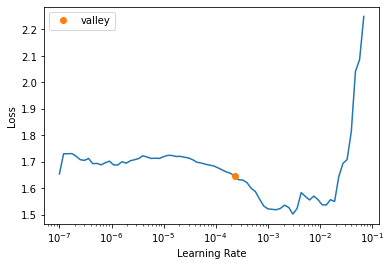

In [7]:
learn.lr_find()

In [8]:
learn.fit_one_cycle(1, lr_max=1e-3)

epoch,train_loss,valid_loss,f1_score,time
0,0.505243,0.403690,[0.68321513 0.68323638 0.71084337 0.89770771 0.8602989 ],04:44


In [9]:
learn.show_results(learner=learn, max_n=5)

,text,category,target
0,"Quedan reservadas, en todo caso, a las Fuerzas y Cuerpos de Seguridad del Estado bajo la dependencia del Gobierno los servicios policiales de carácter extracomunitario y supracomunitario como la vigilancia de puertos, aeropuertos, costas y fronteras, aduanas, control de entrada y salida del territorio nacional de españoles y extranjeros, régimen general de extranjería, extradición y expulsión, emigración e inmigración, pasaportes, documento nacional de identidad, trafico, armas y explosivos, resguardo fiscal del Estado, contrabando y fraude fiscal y las demás funciones que directamente les encomienda el artículo 104 de la Constitución [19] y las que les atribuya la Ley orgánica que lo desarrolle.",legal,legal
1,"Pero la señora Robinson reconoce también estar en deuda, o en cierto parentesco intelectual, con otros cuantos colegas, de los cuales citaremos particularmente a tres: primero, HARROD, cuya aportación al análisis de las estructuras impura o imperfectamente competitivas se tiene que estimar en más de lo que indican por sí mismos sus artículos (incluyendo su ""Doctrines of Imperfect Competition"", Quarterly Journal of Economics mayo de 1934, ""Imperfect Competition and the Trade Cycle"", Revievw of Economie Statistics, mayo de 1936, y ""Price and Cost in Entrepreneurs' Policy"", Oxford Economic Papers, mayo de 1939), sobre todo si se tienen en cuenta sus fechas de publicación.",economía,economía
2,"A continuación aparecen xxx y xxx junto con xxx el invariable complejo transductor de señal del receptor del linfocito T y luego das células comienzan a expresar las cadenas variables del receptor del linfocito T. En esta etapa las células no se colorean para xxx o xxx de superficie, los marcadores de subtipos helper/inductor y citotóxico/supresor respectivamente, pero luego, las células que han reorganizado sus genes para el receptor de linfocitos xxx pasan a ser dobles positivas para xxx.",medicina,medicina
3,"Se deduce de esto que un aumento en la cantidad de dinero no tendrá el menor efecto sobre los precios mientras haya alguna desocupación, y que la ocupación subirá exactamente en proporción a cualquier aumento de la demanda efectiva producida por la elevación de la cantidad de dinero; mientras que, tan pronto como se alcance la ocupación plena, la unidad de salarios y los precios serán los que crecerán en proporción exacta al aumento de la demanda efectiva.",economía,economía
4,"Los Estados miembros adoptarán las disposiciones necesarias para garantizar que todos los vehículos para desguace son almacenados (incluso temporalmente) y tratados con arreglo a los requisitos generales establecidos en el artículo 4 de la Directiva 75/442/CEE, y de conformidad con los requisitos técnicos enumerados en el Anexo de la presente Directiva, sin perjuicio de lo dispuesto en la normativa nacional relativa a la salud y al medio ambiente.",ambiente,ambiente


### Evaluar

In [10]:
val_res = learn.validate()

val_res_d = { 'loss': val_res[0]}
for idx, m in enumerate(learn.metrics):
    val_res_d[m.name] = val_res[idx+1]
    
val_res_d

{'f1_score': array([0.68321513, 0.68323638, 0.71084337, 0.89770771, 0.8602989 ]),
 'loss': 0.40369001030921936}

In [11]:
preds, targs, losses = learn.get_preds(with_loss=True)
print(preds.shape, targs.shape, losses.shape)
print(losses.mean(), accuracy(preds, targs))

torch.Size([10471, 5]) torch.Size([10471]) torch.Size([10471])
TensorBase(0.4037) TensorBase(0.8485)


### Infererir

In [12]:
learn.export('iula_learner.pkl')

In [13]:
inf_learn = load_learner('iula_learner.pkl')

In [14]:
inf_learn.blurr_predict(pd.DataFrame([
    {'sentence': 'Según el BCE la inflación en el próximo año será menor al 2%'},
    {'sentence': 'La cardiopatía congénita es tratable vía transplante'},
    {'sentence': 'Altos niveles de CO2 durante la calima.'},
    {'sentence': 'Las partículas de 20 micrones pueden producir neumonías.'},
]))

[(('economía',),
  (#1) [tensor(1)],
  (#1) [tensor([0.0326, 0.9395, 0.0009, 0.0249, 0.0021])]),
 (('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([7.8781e-04, 5.7285e-04, 4.8184e-05, 9.9621e-01, 2.3820e-03])]),
 (('ambiente',),
  (#1) [tensor(0)],
  (#1) [tensor([9.9081e-01, 8.5755e-04, 5.9832e-04, 6.5957e-03, 1.1391e-03])]),
 (('medicina',),
  (#1) [tensor(3)],
  (#1) [tensor([5.9802e-02, 1.6975e-02, 8.7026e-04, 8.9083e-01, 3.1528e-02])])]